In [22]:
from pathlib import Path
import os
import sys

dirname = Path(os.path.abspath(''))
root = dirname.parent

sys.path.insert(0, str(root))

In [23]:
# Constants

WINDOW_SIZE = 32
PREDICTION_SIZE = 4

STYLE_BULLISH = [1, 0, 0]
STYLE_UNKNOWN = [0, 1, 0]
STYLE_BEARISH = [0, 0, 1]

Y_DIM = len(STYLE_BULLISH)

VALIDATION_RATIO = 0.2

BATCH_SIZE = 64

EPOCHS = 100

BOLL_PERIODS = 21

PRICE_INDICATORS = [
    f'boll:{BOLL_PERIODS}',
    f'boll.upper:{BOLL_PERIODS}',
    f'boll.lower:{BOLL_PERIODS}',
]

INDICATORS = [
    'kdj.j',
    'kdjc.j',
    *PRICE_INDICATORS
]

PRICE_COLUMNS = [
    'open',
    'high',
    'low',
    'close'
]

In [24]:
import pandas as pd
from stock_pandas import StockDataFrame

stock = StockDataFrame(
    pd.read_csv(root / 'data' / '15m.csv', index_col=0).drop(columns=['open_time', 'close_time'])
)

# Remove zero volumn records
stock = stock[
    (stock != 0).all(axis=1)
].dropna()

original_columns = list(stock.columns)
indicator_columns = []

for indicator in INDICATORS:
    stock[indicator]
    name = stock.directive_stringify(indicator)
    
    indicator_columns.append(name)
    
    if indicator in PRICE_INDICATORS:
        PRICE_COLUMNS.append(name)
        
all_columns = original_columns + indicator_columns

stock = stock[all_columns]

stock

,open,high,low,close,volume,quote_volume,total_trades,taker_volume,taker_quote_volume,"kdj.j:9,3,3,50.0","kdjc.j:9,3,3,50.0","boll:21,close","boll.upper:21,2.0,close","boll.lower:21,2.0,close"
0,7145.99,7161.38,7117.12,7137.44,552.274946,3.943150e+06,4627,299.994641,2.142624e+06,11.111111,11.111111,NaN,NaN,NaN
1,7137.46,7173.47,7137.45,7151.58,472.460817,3.381481e+06,4308,292.893319,2.096191e+06,-7.407407,-7.407407,NaN,NaN,NaN
2,7151.58,7167.00,7138.39,7156.53,302.007414,2.159535e+06,3728,183.059632,1.308919e+06,-14.814815,-14.814815,NaN,NaN,NaN
3,7156.04,7157.07,7133.52,7136.57,320.142548,2.286677e+06,3319,148.957600,1.063991e+06,-16.460905,-16.460905,NaN,NaN,NaN
4,7136.76,7141.99,7114.33,7120.10,378.542200,2.696923e+06,3524,171.678416,1.223234e+06,-15.363512,-15.363512,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39343,34418.14,34453.42,34231.76,34270.00,646.597006,2.220679e+07,14633,283.665493,9.742730e+06,65.651815,72.918403,33984.856190,34478.142812,33491.569569
39344,34269.99,34315.77,34080.00,34222.31,817.366831,2.794088e+07,17787,439.794978,1.503755e+07,52.393453,28.873614,34012.296190,34491.042088,33533.550293
39345,34223.23,34683.63,34191.49,34663.87,2406.594609,8.287577e+07,31952,1269.885942,4.374530e+07,80.965149,69.516029,34060.048095,34586.780713,33533.315477
39346,34663.87,35469.38,34663.87,35312.54,4131.153799,1.451840e+08,72106,2360.816279,8.293755e+07,89.153805,90.966432,34143.963333,34850.077339,33437.849327


In [25]:
ranges_map = {}
all_mins = []
all_maxes = []


for column_name in stock.columns:
    column = stock[column_name]
    mi = column.min()
    ma = column.max()
    
    if column_name not in PRICE_COLUMNS:
        ranges_map[column_name] = (mi, ma)
    else:
        all_mins.append(mi)
        all_maxes.append(ma)
        
all_min = min(*all_mins)
all_max = max(*all_maxes)
        
for column_name in PRICE_COLUMNS:
    ranges_map[column_name] = (all_min, all_max)
    
ranges = []

for column_name in stock.columns:
    ranges.append(ranges_map[column_name])
    
print(ranges_map)

ranges

{'volume': (1.565351, 20821.081669), 'quote_volume': (52898.31577903, 437063159.1944714), 'total_trades': (165, 196911), 'taker_volume': (0.586205, 9002.998558), 'taker_quote_volume': (19810.42841852, 266415502.5008489), 'kdj.j:9,3,3,50.0': (-19.4876226926773, 121.2584343260836), 'kdjc.j:9,3,3,50.0': (-30.637980066429577, 129.6418459221855), 'open': (3782.13, 42706.03273362761), 'high': (3782.13, 42706.03273362761), 'low': (3782.13, 42706.03273362761), 'close': (3782.13, 42706.03273362761), 'boll:21,close': (3782.13, 42706.03273362761), 'boll.upper:21,2.0,close': (3782.13, 42706.03273362761), 'boll.lower:21,2.0,close': (3782.13, 42706.03273362761)}


[(3782.13, 42706.03273362761),
 (3782.13, 42706.03273362761),
 (3782.13, 42706.03273362761),
 (3782.13, 42706.03273362761),
 (1.565351, 20821.081669),
 (52898.31577903, 437063159.1944714),
 (165, 196911),
 (0.586205, 9002.998558),
 (19810.42841852, 266415502.5008489),
 (-19.4876226926773, 121.2584343260836),
 (-30.637980066429577, 129.6418459221855),
 (3782.13, 42706.03273362761),
 (3782.13, 42706.03273362761),
 (3782.13, 42706.03273362761)]

In [26]:
def is_hhv(array) -> bool:
    return array[0] == array.max()


def is_llv(array) -> bool:
    return array[0] == array.min()

        
original_n = len(stock.columns)

stock['is_hhv'] = stock.rolling_calc(
    PREDICTION_SIZE + 1,
    'high',
    is_hhv,
    True
)

stock['is_llv'] = stock.rolling_calc(
    PREDICTION_SIZE + 1,
    'low',
    is_llv,
    True
)

stock

,open,high,low,close,volume,quote_volume,total_trades,taker_volume,taker_quote_volume,"kdj.j:9,3,3,50.0","kdjc.j:9,3,3,50.0","boll:21,close","boll.upper:21,2.0,close","boll.lower:21,2.0,close",is_hhv,is_llv
0,7145.99,7161.38,7117.12,7137.44,552.274946,3.943150e+06,4627,299.994641,2.142624e+06,11.111111,11.111111,NaN,NaN,NaN,0.0,0.0
1,7137.46,7173.47,7137.45,7151.58,472.460817,3.381481e+06,4308,292.893319,2.096191e+06,-7.407407,-7.407407,NaN,NaN,NaN,1.0,0.0
2,7151.58,7167.00,7138.39,7156.53,302.007414,2.159535e+06,3728,183.059632,1.308919e+06,-14.814815,-14.814815,NaN,NaN,NaN,1.0,0.0
3,7156.04,7157.07,7133.52,7136.57,320.142548,2.286677e+06,3319,148.957600,1.063991e+06,-16.460905,-16.460905,NaN,NaN,NaN,0.0,0.0
4,7136.76,7141.99,7114.33,7120.10,378.542200,2.696923e+06,3524,171.678416,1.223234e+06,-15.363512,-15.363512,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39343,34418.14,34453.42,34231.76,34270.00,646.597006,2.220679e+07,14633,283.665493,9.742730e+06,65.651815,72.918403,33984.856190,34478.142812,33491.569569,0.0,0.0
39344,34269.99,34315.77,34080.00,34222.31,817.366831,2.794088e+07,17787,439.794978,1.503755e+07,52.393453,28.873614,34012.296190,34491.042088,33533.550293,NaN,NaN
39345,34223.23,34683.63,34191.49,34663.87,2406.594609,8.287577e+07,31952,1269.885942,4.374530e+07,80.965149,69.516029,34060.048095,34586.780713,33533.315477,NaN,NaN
39346,34663.87,35469.38,34663.87,35312.54,4131.153799,1.451840e+08,72106,2360.816279,8.293755e+07,89.153805,90.966432,34143.963333,34850.077339,33437.849327,NaN,NaN


In [27]:
import numpy as np


features = stock.to_numpy()[BOLL_PERIODS:-PREDICTION_SIZE]

original_n = len(ranges)


def normalize(value, index):
    min_value, max_value = ranges[index]
    
    return (value - min_value) / (max_value - min_value) 


def apply_normalizer(array: np.ndarray) -> np.ndarray:
    return [
        normalize(value, i)
        for i, value in enumerate(array)
    ]


def apply_softmax(array: np.ndarray) -> np.ndarray:
    origin = array[:original_n]
    is_hhv, is_llv = array[original_n:]
    
    row = np.append(
        apply_normalizer(origin),
        STYLE_BULLISH if is_llv == 1 else (
            STYLE_BEARISH if is_hhv == 1 else STYLE_UNKNOWN
        )
    )
    
    return row


features = np.array([
    apply_softmax(row)
    for row in features
])

print('inputs length', len(features))

features

inputs length 39320


array([[0.08664907, 0.08695402, 0.08663391, ..., 0.        , 1.        ,
        0.        ],
       [0.08673128, 0.08678138, 0.08601784, ..., 0.        , 1.        ,
        0.        ],
       [0.08614681, 0.08706064, 0.08595978, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.78413771, 0.78532387, 0.7814702 , ..., 0.        , 1.        ,
        0.        ],
       [0.78207086, 0.7889697 , 0.78188177, ..., 0.        , 1.        ,
        0.        ],
       [0.78707447, 0.78798085, 0.78228615, ..., 0.        , 1.        ,
        0.        ]])

In [28]:
def get_labels_from_features(features):
    return features[WINDOW_SIZE - 1:, -Y_DIM:]


def split_by_ratio(features):
    length = len(features)
    validation_length = int(VALIDATION_RATIO * length)
    
    return features[:-validation_length], features[-validation_length:]


training_features, validation_features = split_by_ratio(features)

print('training length', len(training_features))
print('validation length', len(validation_features))

training length 31456
validation length 7864


In [29]:
import tensorflow as tf
from get_rolling_window import rolling_window

train_ds = tf.data.Dataset.from_tensor_slices((
    rolling_window(training_features, WINDOW_SIZE, 1), 
    get_labels_from_features(training_features)
)).batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_tensor_slices((
    rolling_window(validation_features, WINDOW_SIZE, 1), 
    get_labels_from_features(validation_features)
)).batch(BATCH_SIZE)

train_ds

<BatchDataset shapes: ((None, 32, 17), (None, 3)), types: (tf.float64, tf.float64)>

In [30]:
from da_rnn import DARNN
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Reshape

darnn = DARNN(
    WINDOW_SIZE,
    64,
    64,
    Y_DIM
)

model = Sequential([
    darnn,
    Reshape((-1,), name='reshape')
])


# model.summary()

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy', 'mae', 'mape']
)

In [31]:
feature_batch, label_batch = next(iter(train_ds))

print('feature, label shape', feature_batch.shape, label_batch.shape)

print('prediction shape', model(feature_batch).shape)

model(feature_batch[:1])

feature, label shape (64, 32, 17) (64, 3)
prediction shape (64, 3)


<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.00368001,  0.00213088,  0.00015653]], dtype=float32)>

In [32]:
save_to = dirname / 'checkpoint.hdf5'

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[
        # Save checkpoints on best validation loss
        tf.keras.callbacks.ModelCheckpoint(
            save_to,
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        # Stop early if the model overfits
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    ],
    epochs=EPOCHS,
    verbose=1
)

history

Epoch 1/100
492/492 [==============================] - 129s 119ms/step - loss: 1.0446 - accuracy: 0.4497 - mae: 0.4730 - mape: 177549158.1055 - val_loss: 0.9811 - val_accuracy: 0.5057 - val_mae: 0.6042 - val_mape: 357154944.0000

Epoch 00001: val_loss improved from inf to 0.98107, saving model to /Users/kael/Codes/ml/tensorflow-2-DA-RNN/notebook/checkpoint.hdf5
Epoch 2/100
492/492 [==============================] - 38s 77ms/step - loss: 0.9930 - accuracy: 0.4992 - mae: 0.5899 - mape: 332224752.8763 - val_loss: 0.9843 - val_accuracy: 0.4890 - val_mae: 0.6368 - val_mape: 386787136.0000

Epoch 00002: val_loss did not improve from 0.98107
Epoch 3/100
492/492 [==============================] - 38s 78ms/step - loss: 0.9867 - accuracy: 0.4936 - mae: 0.6019 - mape: 347470225.2008 - val_loss: 0.9880 - val_accuracy: 0.4805 - val_mae: 0.6608 - val_mape: 409313152.0000

Epoch 00003: val_loss did not improve from 0.98107
Epoch 4/100
492/492 [==============================] - 39s 80ms/step - loss: 0

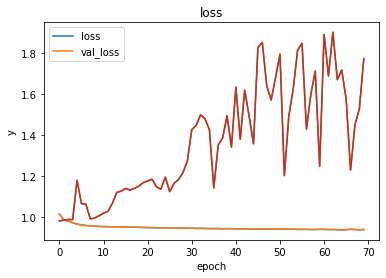

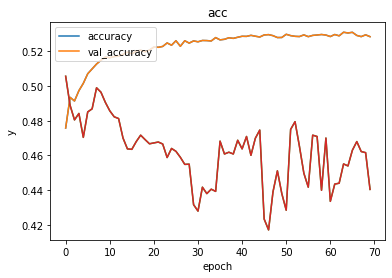

In [33]:
import matplotlib.pyplot as plt


def plot(keys, title='title', ylabel='y'):
    for key in keys:
        plt.plot(history.history[key])
        plt.plot(history.history[key])
        
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('epoch')
    
    plt.legend(keys, loc='upper left')
    
    plt.show()
    
plot(['loss', 'val_loss'], 'loss')
plot(['accuracy', 'val_accuracy'], 'acc')
